In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [58]:
# Load the dataset (assuming the file is in the same directory)
# If using Google Colab, upload the file first
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/E-commerce%20Customer%20Behavior%20-%20Sheet1.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (350, 11)


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,"1,120.20",14,4.60,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.10,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.40,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,"1,480.30",19,4.70,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.00,True,55,Unsatisfied


In [59]:
# 1. Map Ordinal Variables (Satisfaction Level) to Numbers
# 'Unsatisfied' -> 0, 'Neutral' -> 1, 'Satisfied' -> 2
satisfaction_map = {'Unsatisfied': 0, 'Neutral': 1, 'Satisfied': 2, 'High': 3, 'Medium': 2, 'Low': 0} # Included extra keys just in case
df['Satisfaction_Numeric'] = df['Satisfaction Level'].map(satisfaction_map)

# 2. Convert 'Discount Applied' to Integer (True/False -> 1/0)
df['Discount_Numeric'] = df['Discount Applied'].astype(int)

# 3. Handle 'Gender' using One-Hot Encoding later, or map it simply here
df['Gender_Numeric'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Drop rows with missing values in critical columns if any (optional but safer)
df = df.dropna(subset=['Total Spend', 'Items Purchased', 'Average Rating'])

# Fill missing Satisfaction with mode (most frequent)
df['Satisfaction_Numeric'] = df['Satisfaction_Numeric'].fillna(df['Satisfaction_Numeric'].mode()[0])

print("Preprocessing complete. New columns added.")
df[['Gender', 'Gender_Numeric', 'Satisfaction Level', 'Satisfaction_Numeric']].head()

Preprocessing complete. New columns added.


,Gender,Gender_Numeric,Satisfaction Level,Satisfaction_Numeric
0,Female,1,Satisfied,2.00
1,Male,0,Neutral,1.00
2,Female,1,Unsatisfied,0.00
3,Male,0,Satisfied,2.00
4,Male,0,Unsatisfied,0.00


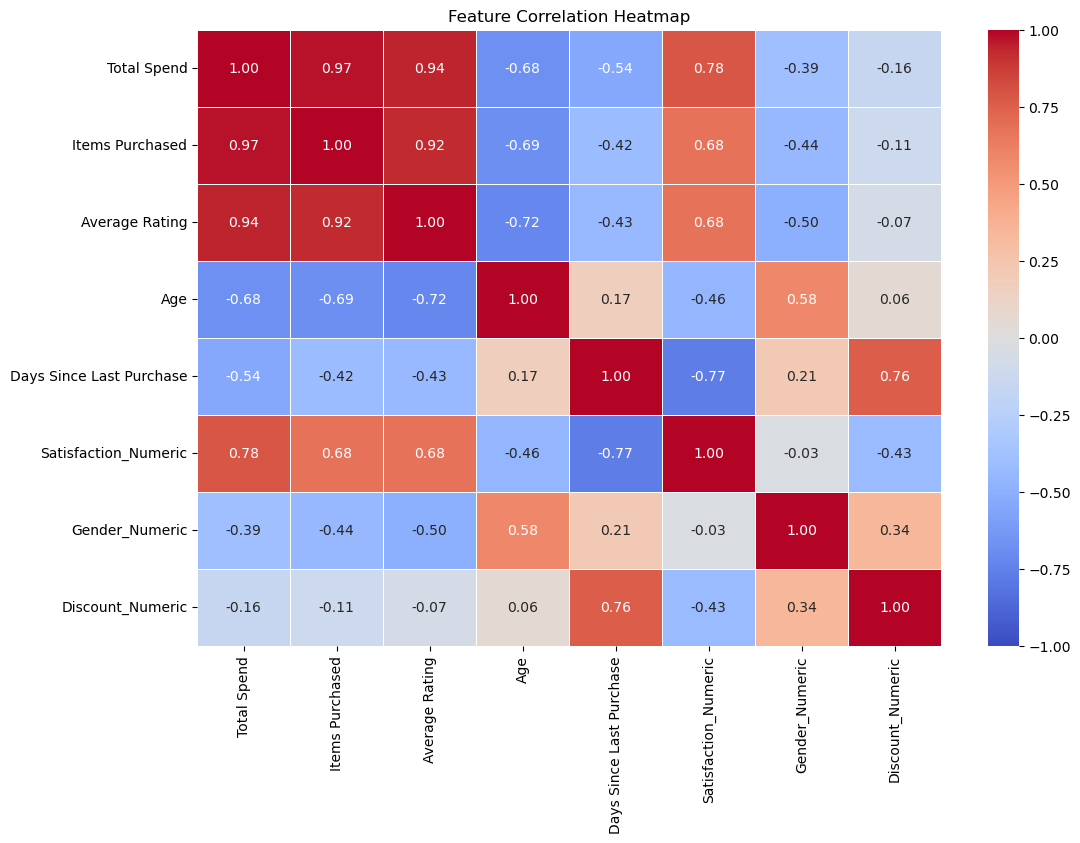

In [60]:
# Cell: Correlation Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select the relevant numeric columns for correlation
# We include the features we created + the target variable 'Total Spend'
correlation_cols = [
    'Total Spend', 
    'Items Purchased', 
    'Average Rating', 
    'Age', 
    'Days Since Last Purchase', 
    'Satisfaction_Numeric', 
    'Gender_Numeric', 
    'Discount_Numeric'
]

# 2. Compute the correlation matrix
corr_matrix = df[correlation_cols].corr()

# 3. Plot the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True,        # Show the numbers
            cmap='coolwarm',   # Red = Positive, Blue = Negative
            fmt=".2f",         # 2 decimal places
            linewidths=0.5,    # White lines between squares
            vmin=-1, vmax=1)   # Scale from -1 to 1

plt.title("Feature Correlation Heatmap")
plt.show()

In [61]:
# Target Variable
y = df['Total Spend']

# Select Features
# We use the numeric versions we just created
features = ['Age', 
            'Gender_Numeric', 
            'Items Purchased', 
            'Average Rating', 
            'Discount_Numeric', 
            'Days Since Last Purchase', 
            'Satisfaction_Numeric']

X = df[features]

print("Features (X):", X.shape)
print("Target (y):", y.shape)

# Double check for any remaining NaNs
print("\nMissing values in X:\n", X.isnull().sum())


Features (X): (350, 7)
Target (y): (350,)

Missing values in X:
 Age                         0
Gender_Numeric              0
Items Purchased             0
Average Rating              0
Discount_Numeric            0
Days Since Last Purchase    0
Satisfaction_Numeric        0
dtype: int64


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Testing set:  {X_test.shape}")

Training set: (280, 7)
Testing set:  (70, 7)


In [63]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Linear Regression Model trained successfully.")
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(features, model.coef_)))

Linear Regression Model trained successfully.
Intercept: -133.47293486022318
Coefficients: {'Age': np.float64(-1.9192476993366894), 'Gender_Numeric': np.float64(-10.637962717546838), 'Items Purchased': np.float64(57.18792129416664), 'Average Rating': np.float64(86.85864314048582), 'Discount_Numeric': np.float64(99.05740198148018), 'Days Since Last Purchase': np.float64(-5.111662587974138), 'Satisfaction_Numeric': np.float64(62.235300745773664)}


In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Make Predictions
y_pred = model.predict(X_test)

# 2. Calculate Standard Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 3. Calculate MAPE (Mean Absolute Percentage Error)
# We use a mask to ensure we don't divide by zero if any actual value is 0
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

# 4. Create a DataFrame for a Professional Table
metrics_table = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error (MAE)', 
        'Mean Squared Error (MSE)', 
        'Root Mean Squared Error (RMSE)', 
        'R-Squared (R²)', 
        'Mean Abs. % Error (MAPE)'
    ],
    'Value': [mae, mse, rmse, r2, mape]
})

# Optional: Format the numbers nicely (e.g., 2 decimal places)
# This keeps the underlying data numeric but displays it as a string
pd.options.display.float_format = '{:,.2f}'.format

print("--- Model Performance Summary ---")
display(metrics_table) 
# Note: If not using Jupyter, use 'print(metrics_table)' instead of 'display'

--- Model Performance Summary ---


,Metric,Value
0,Mean Absolute Error (MAE),33.62
1,Mean Squared Error (MSE),"1,918.91"
2,Root Mean Squared Error (RMSE),43.81
3,R-Squared (R²),0.99
4,Mean Abs. % Error (MAPE),3.83


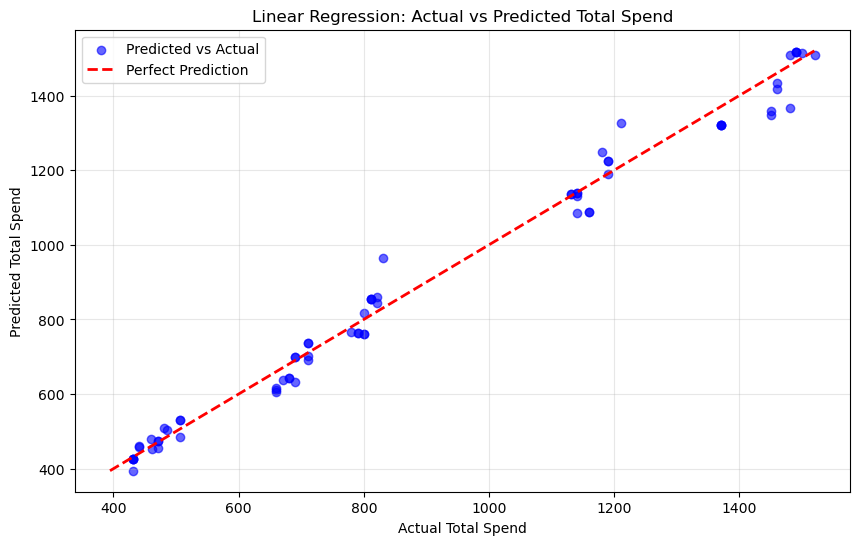

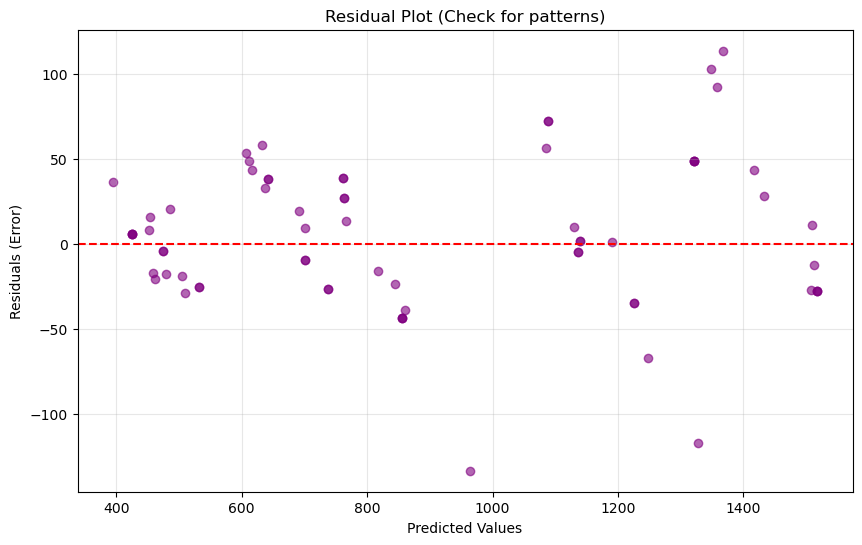

In [65]:
plt.figure(figsize=(10, 6))

# Scatter plot of Actual vs Predicted
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')

# Perfect prediction line (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Total Spend")
plt.ylabel("Predicted Total Spend")
plt.title("Linear Regression: Actual vs Predicted Total Spend")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Residual Plot (Optional but good for Regression)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot (Check for patterns)")
plt.grid(True, alpha=0.3)
plt.show()

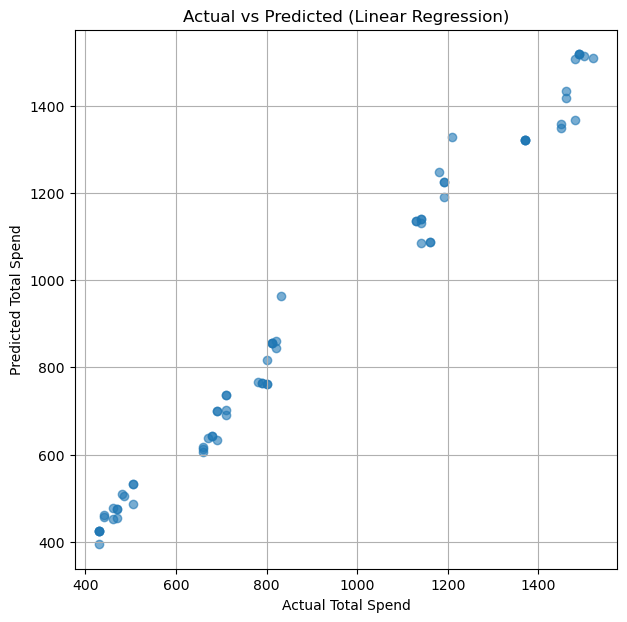

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Total Spend")
plt.ylabel("Predicted Total Spend")
plt.title("Actual vs Predicted (Linear Regression)")
plt.grid(True)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_5980\4016547834.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


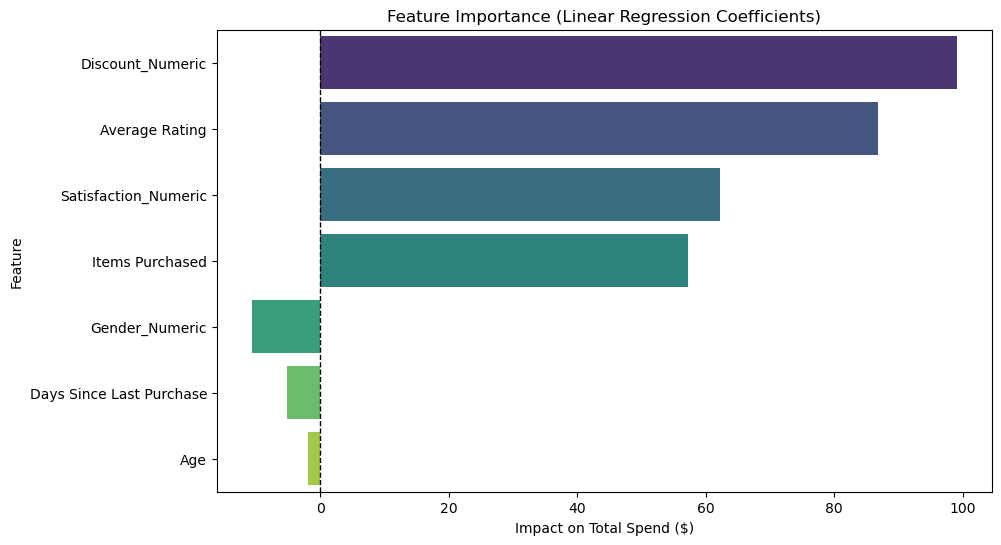

In [67]:
# Cell: Feature Importance Visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': features, # Ensure 'features' list from previous cells is available
    'Coefficient': model.coef_
})

# Sort by absolute value to show most impactful features first
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Impact on Total Spend ($)")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.show()

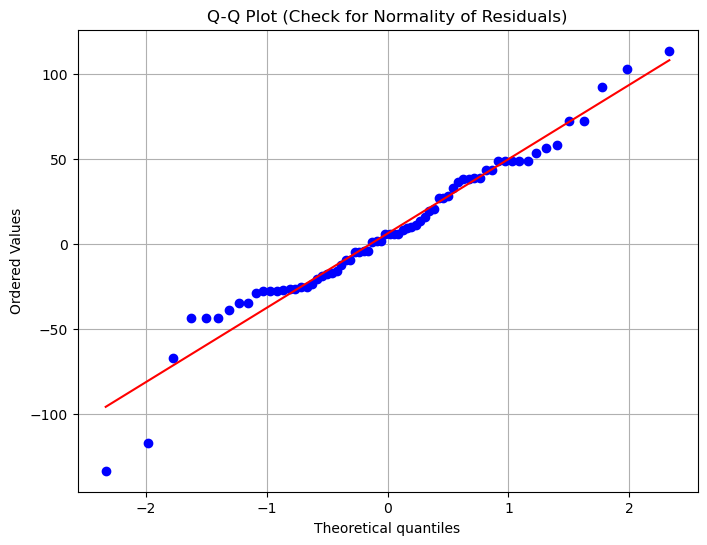

In [68]:
# Cell: Q-Q Plot for Normality Check
import scipy.stats as stats

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot (Check for Normality of Residuals)")
plt.grid(True)
plt.show()

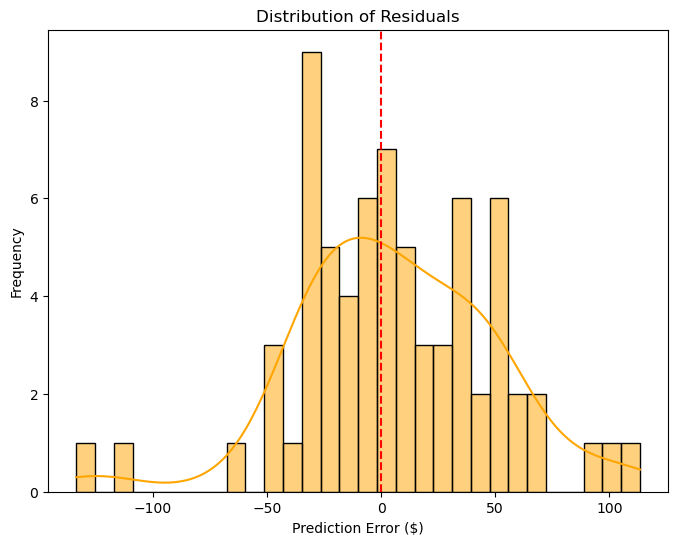

In [69]:
# Cell: Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='orange')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error ($)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--') # Zero error line
plt.show()